In [20]:
import numpy as np 
import pandas as pd 
import os
import cv2 
import PIL 
import gc
import psutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow import set_random_seed
from tqdm import tqdm
from math import ceil

import keras
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.applications import DenseNet121
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.activations import softmax, relu
from keras.optimizers import Adam

from keras.layers import BatchNormalization

from tqdm import tqdm

# Global constants
IMG_DIM      = 256
BATCH_SIZE   = 32
CHANNEL_SIZE = 3
ZOOM         = 0.8
NUM_CLASSES  = 5

class_names = {"0":"No DR", "1":"Mild", "2":"Moderate", "3":"Severe", "4":"Proliferative DR"}

Index(['id_code', 'diagnosis', '0', '1', '2', '3', '4'], dtype='object')

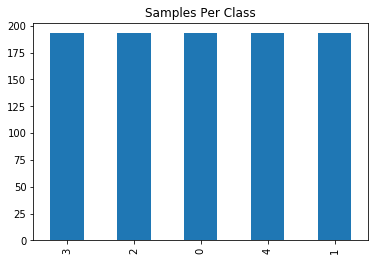

In [8]:
SEED = 7
np.random.seed(SEED) 
set_random_seed(SEED)


class_to_val = [[0.85, 0.1, 0.05, 0, 0],
                [0.1, 0.8, 0.1, 0, 0],
                [0, 0.15, 0.7, 0.15, 0],
                [0, 0, 0.1, 0.8, 0.1], 
                [0, 0, 0.05, 0.1, 0.85]]

def getDF(year="2019", dataset="train"):
    
    # take in data, remap images, standardise data
    if (year == "2019"):
        df         = pd.read_csv(f"../aptos2019/{dataset}.csv") 
        df.id_code = df.id_code.apply(lambda x: x + ".png")
    elif (year == "2015"):
        df       = pd.read_csv("../aptos2015/trainLabels.csv") 
        df.image = df.image.apply(lambda x: x + ".jpeg")
        
        df["id_code"]   = df.image
        df["diagnosis"] = df.level
    else:
        print("not implemented")
        exit()
        
    # if test, we're done
    if dataset == "test":
        return df
    
    # shuffle data so each time different samples are dropped
    df = df.sample(frac=1)
    
    # remap from classes to smoothed version of the classes
    for i in range(5):
        df[str(i)] = df.diagnosis.apply(lambda x: class_to_val[x][i])

    df.diagnosis = df.diagnosis.astype('str')

    # drop classes 
    min_num = min(df['diagnosis'].value_counts())
    
    for diagnosis in range(5):
        indexes = df[df['diagnosis'] == str(diagnosis)].index
        frac_drop = indexes.size * (1 - min_num/indexes.size)
        df.drop(indexes[:int(frac_drop)], inplace=True)

    # shuffle it for even distribution later
    df = df.sample(frac=1)
    
    return df

# plot example
df_to_plot = getDF(year="2019")
df_to_plot['diagnosis'].value_counts().plot(kind='bar')
plt.title('Samples Per Class')

df_example.columns

In [10]:
# assumes RGB
def colourfulEyes(img):
        
    # convert to y, cr, cb so that we can modify the image based on just the y (brightness)
    ycc = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    y, cr, cb = cv2.split(ycc)

    # perform bens algorithm on the y component
    y = cv2.addWeighted(y, 3, cv2.GaussianBlur(y, (0,0), 60),-3, 128)

    # merge the ycc back together, and recolor it
    ycc_modified = cv2.merge((y, cr, cb))
    rgb_modified = cv2.cvtColor(ycc_modified, cv2.COLOR_YCrCb2RGB)
    
    return rgb_modified 

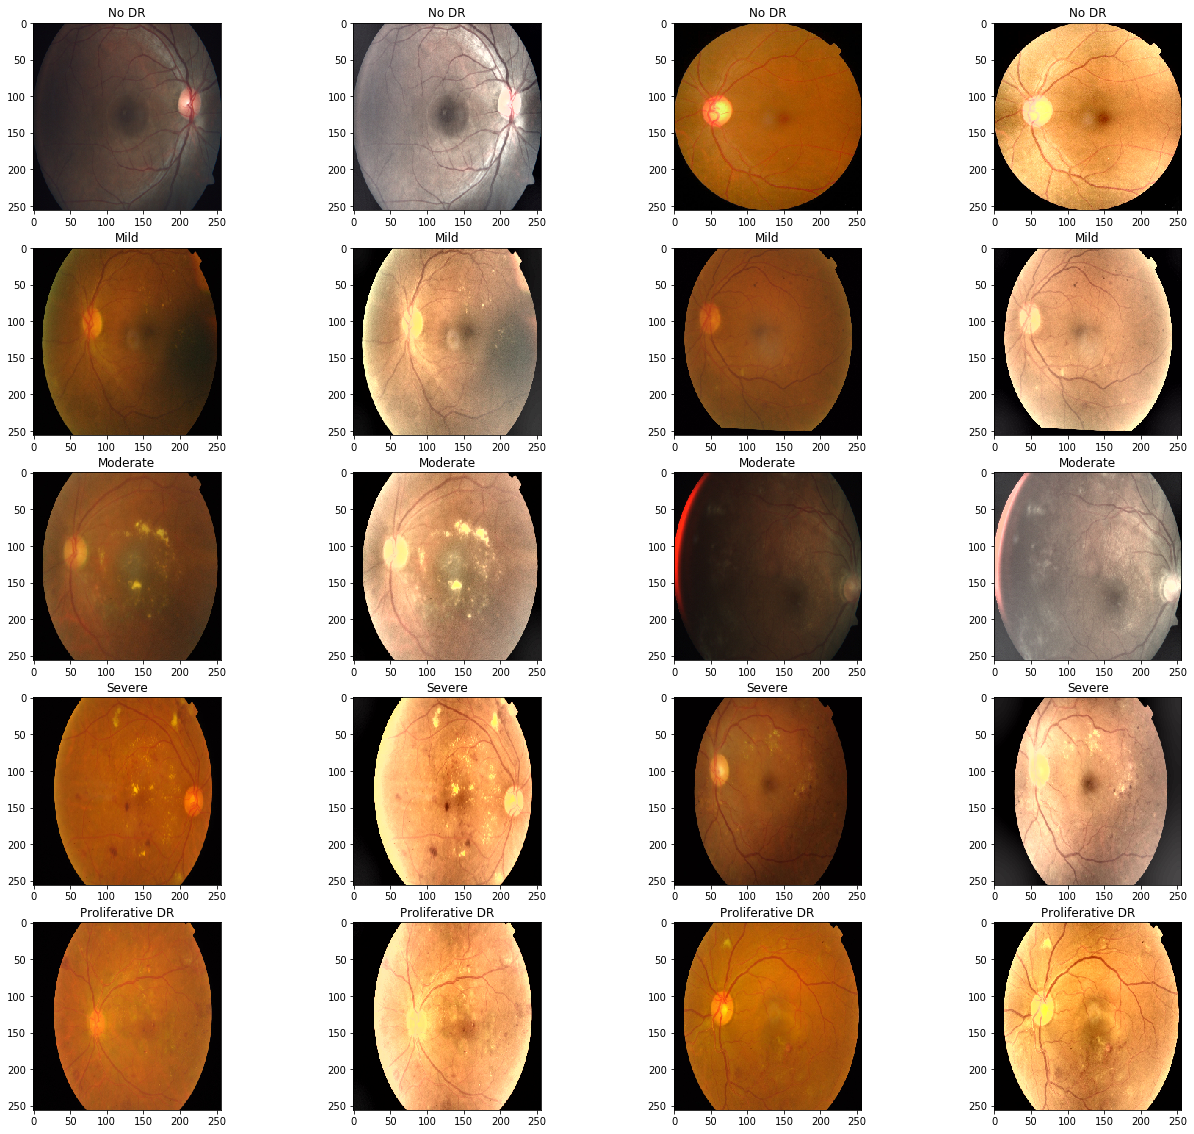

In [11]:
#display some data
df_example = getDF(year="2019")

# Display some random images from Data Set with class categories.
figure=plt.figure(figsize=(22,20))
for target_class in (df_example['diagnosis'].unique()):
    for i, (idx, row ) in enumerate(df_example.loc[df_example.diagnosis == target_class]
                                    .sample(2)
                                    .iterrows()):
        # open the file
        imagefile = f"../aptos2019/train_images/{row['id_code']}" 
        img = cv2.imread(imagefile)
        img = cv2.resize(img, (IMG_DIM, IMG_DIM))
        
        # original version
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = figure.add_subplot(5,4, int(target_class)*4+2*i+1)
        plt.imshow(rgb)
        ax.set_title(class_names[target_class])
        
        # colored version
        funky = colourfulEyes(rgb)
        ax = figure.add_subplot(5,4, int(target_class)*4+2*i+2)
        plt.imshow(funky)
        ax.set_title(class_names[target_class])


In [28]:
# Data generators, which put their data into a random crop generator, which is then fed into
# the network during training

def dataGenerator(jitter=0.1):
    datagen = image.ImageDataGenerator(rescale=1./255,
                                       validation_split=0.2,
                                       horizontal_flip=True, 
#                                        vertical_flip=True,
#                                        rotation_range=20,
                                       width_shift_range=jitter,
                                       height_shift_range=jitter,
                                       shear_range=jitter,
                                       zoom_range=[(1-jitter)*ZOOM, (1+jitter)*ZOOM],
                                       fill_mode="reflect",
                                       preprocessing_function=colourfulEyes
                                      )
    return datagen

def datagen_with_flow(datagen, dataframe, directory, subset):
    return datagen.flow_from_dataframe(dataframe=dataframe, directory=directory,
                                       x_col="id_code", class_mode="raw",
                                       y_col=["0", "1", "2", "3", "4"],
                                       batch_size=BATCH_SIZE,
                                       target_size=(IMG_DIM, IMG_DIM),
                                       subset=subset, interpolation="bilinear",
                                       seed=SEED, shuffle = True)

def generator(jitter=0.1, year="2019"):
    
    df = getDF(year=year) 
    datagen = dataGenerator(jitter)
    
    train_gen = datagen_with_flow(datagen, df, f"../aptos{year}/train_images/", 'training')
    valid_gen = datagen_with_flow(datagen, df, f"../aptos{year}/train_images/", 'validation')
    
    return train_gen, valid_gen

gc.collect()


480

Found 772 validated image filenames.
Found 193 validated image filenames.


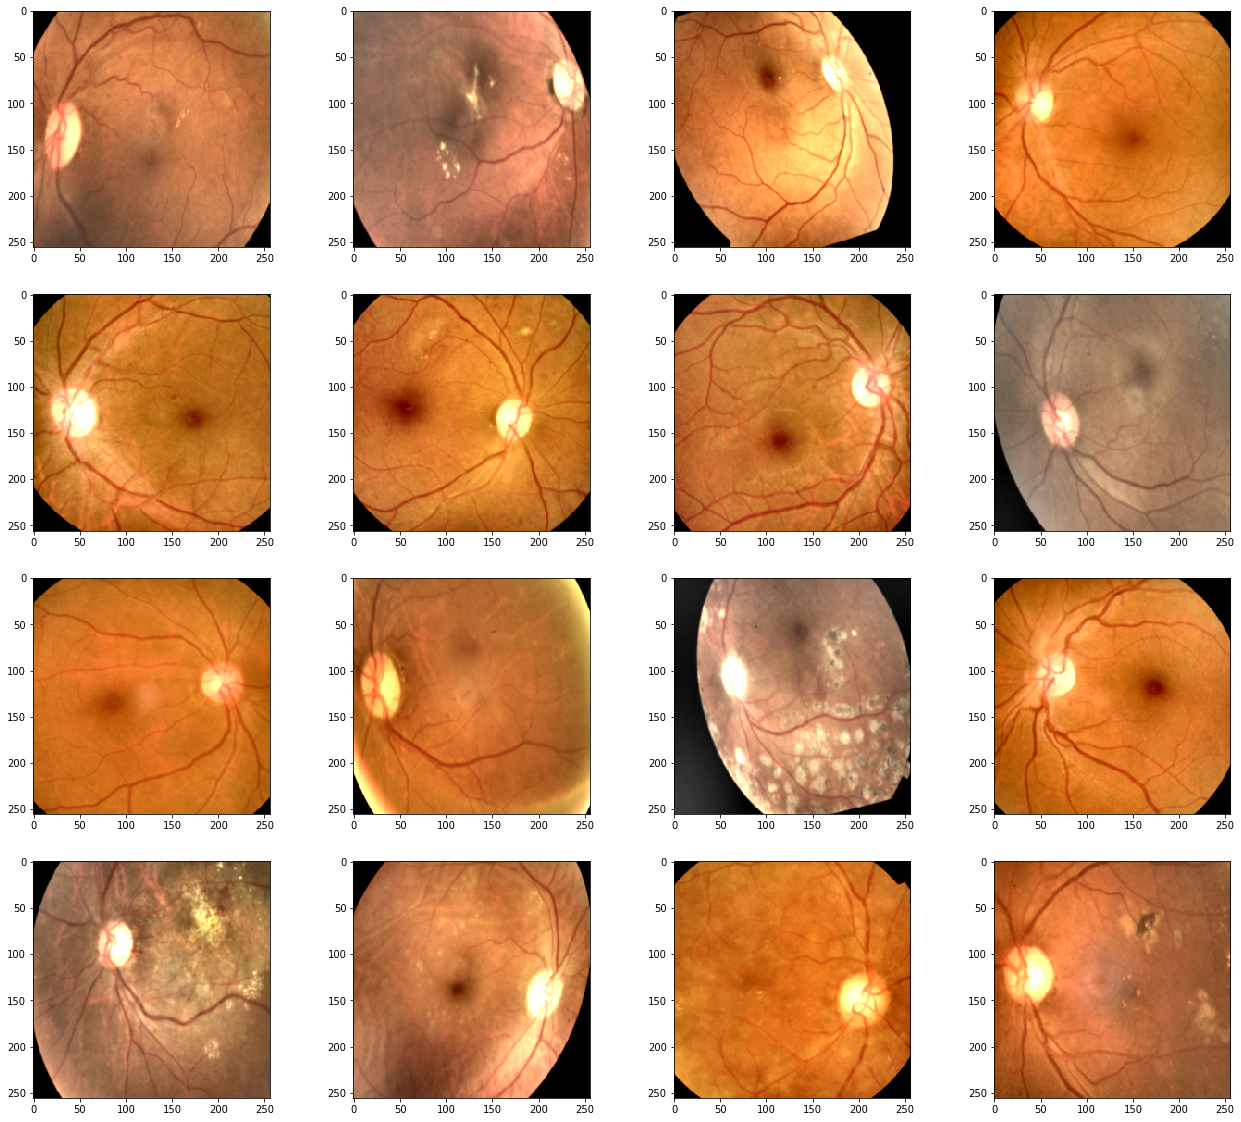

In [13]:
train_sample_gen, valid_sample_gen = generator(jitter=0.05)

# Display some data generation
figure=plt.figure(figsize=(22,20))
for batch in valid_sample_gen:
    for j in range(16):
        ax = figure.add_subplot(4,4, j+1)
        batch[0][j] = np.clip(batch[0][j], 0, 1)
        plt.imshow(batch[0][j])
    break

In [14]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        
        for X_val, y_val in valid_generator:
            y_val= np.argmax(y_val, axis=1)
            preds = model.predict(X_val)
            print(y_val[:5], preds[:5])
            y_pred = np.argmax(preds,axis=1)

            val_kappa = cohen_kappa_score(
                y_val,
                y_pred, 
                weights='quadratic'
            )

            self.val_kappas.append(val_kappa)

            print(f"val_kappa: {val_kappa:.4f}")

            if val_kappa == max(self.val_kappas):
                print("Max of this run, saving model.")
                model.save(f"densenet-{val_kappa:.4f}.h5")
            break


In [25]:
def create_model(img_dim, CHANNELS, n_class):
    
    input_tensor=Input(shape=(img_dim, img_dim, CHANNELS))
    
#     base_model = ResNet50(weights=None, include_top=False, input_tensor=input_tensor)
#     base_model.load_weights('../resnet50/base.h5')
    base_model = DenseNet121(weights=None, include_top=False, input_tensor=input_tensor)
#     base_model.load_weights('../DenseNet-BC-121-32-no-top.h5')
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.2)(x)
    x = Dense(512,  activation=relu)(x)
    x = Dropout(0.15)(x)
    x = BatchNormalization()(x)
    output_layer = Dense(n_class, activation='softmax', name="Output_Layer")(x)
    model = Model(input_tensor, output_layer)
    
    return model

model=create_model(IMG_DIM, CHANNEL_SIZE, NUM_CLASSES)
#     model.load_weights("resnet-0.3283.h5") # with 300 imgsize
model.load_weights("densenet-0.8356.h5") # with 300 imgsize



In [26]:
# todo: don't think this is thinking of frozen layers
for layers in model.layers:
    layers.trainable = True

model.compile(optimizer=Adam(lr=0.00005), loss=keras.losses.mean_squared_error,  metrics=['accuracy'])
gc.collect()

885

In [ ]:
for year in ["2019", "2015", "2019", "2019", "2019"]:

    # these need to be global for the kappa callback
    train_generator, valid_generator = generator(jitter=0.1, year=year)

    # Call backs during training            
    kappa_callbacks = Metrics()
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
    reduce_lr  = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, 
                                   min_lr=1e-7, mode='auto', verbose=1)

    # train the model for 12 epochs
    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=train_generator.n  // train_generator.batch_size,
                                  validation_data=valid_generator,
                                  validation_steps=valid_generator.n // valid_generator.batch_size,
                                  epochs=4,
                                  callbacks=[early_stop, reduce_lr, kappa_callbacks],
                                  verbose=1
                                 )
    gc.collect()

Found 772 validated image filenames.
Found 193 validated image filenames.
Epoch 1/4
24/24 [==============================] - 166s 7s/step - loss: 0.0752 - acc: 0.5221 - val_loss: 0.0619 - val_acc: 0.6042
[2 4 0 2 4] [[0.08877131 0.105749   0.21043079 0.39562345 0.19942546]
 [0.05373051 0.00894579 0.22735883 0.34430647 0.3656584 ]
 [0.9849466  0.00733234 0.00188347 0.00413854 0.00169911]
 [0.08453315 0.8568224  0.0187067  0.00261418 0.03732359]
 [0.00599162 0.0042846  0.15707974 0.4055635  0.4270805 ]]
val_kappa: 0.8143
Max of this run, saving model.
Epoch 2/4
24/24 [==============================] - 81s 3s/step - loss: 0.0684 - acc: 0.5661 - val_loss: 0.0583 - val_acc: 0.6211
[3 4 0 3 1] [[2.8509924e-03 3.7798176e-03 7.7759825e-02 6.3275683e-01 2.8285259e-01]
 [1.9473553e-03 2.0379918e-03 6.1822324e-03 4.9770331e-01 4.9212918e-01]
 [9.8633784e-01 9.3399864e-03 1.6244755e-03 2.4039499e-03 2.9369196e-04]
 [2.9199460e-04 4.4580642e-03 2.5091523e-02 1.3753077e-01 8.3262759e-01]
 [4.9806494

In [ ]:
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
(eval_loss, eval_accuracy)=tqdm(model_resnet.evaluate_generator(generator=valid_generator,steps=NUM_VALID_STEPS, pickle_safe=False))
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 


# as it was, with the eye colouring
# [INFO] accuracy: 84.71%
# [INFO] Loss: 0.45822140898023334

In [ ]:
# test_datagen = image.ImageDataGenerator(rescale=1./255,
#                                         horizontal_flip=True
#                                        )

# test_generator = test_datagen.flow_from_dataframe(dataframe = df_test,
#                                                   directory = "../aptos2019/test_images/",
#                                                   x_col="id_code",
#                                                   target_size=(IMG_DIM, IMG_DIM),
#                                                   batch_size=1,
#                                                   shuffle=False, 
#                                                   class_mode=None, 
#                                                   interpolation="bilinear",
#                                                   seed=SEED
#                                                  )

# del df_test
print(df_test.shape[0])
gc.collect()

In [ ]:
test_datagen = image.ImageDataGenerator(rescale=1./255,
                                        zoom_range=[ZOOM, ZOOM],
                                        preprocessing_function=colourfulEyes
                                       )

test_generator = test_datagen.flow_from_dataframe(dataframe = df_train,
                                                  directory = "../aptos2019/train_images/",
                                                  x_col="id_code",
                                                  target_size=(IMG_DIM, IMG_DIM),
                                                  batch_size=1,
                                                  shuffle=False, 
                                                  interpolation="bilinear",
                                                  seed=SEED
                                                 )
preds = model_resnet.predict_generator(generator=test_generator, steps=50)
preds, df_train